In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sklearn.cluster import KMeans

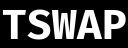

In [2]:
# Step 1. create monochrome image from text

img = Image.new("L", (128, 48))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("$HOME/Library/Fonts/FiraCode-Bold.ttf", 40)  # use your font
draw.multiline_text((2, 2), "TSWAP", fill=(255,), font=font)
img

In [3]:
# Step 2. Identify white pixel positions
npy_img = np.array(img)
white_pixel_positions = np.c_[np.where(npy_img > 200)]
white_pixel_positions[:10]

array([[10,  3],
       [10,  4],
       [10,  5],
       [10,  6],
       [10,  7],
       [10,  8],
       [10,  9],
       [10, 10],
       [10, 11],
       [10, 12]])

In [4]:
# Step 3. Solve k-means clustering

num_agents = 1711
# Safety Check: `num_agents` must not exceed the count of available target pixels.
# If `num_agents` > `len(white_pixel_positions)`, we cap it at the maximum pixel count.
# Rationale: Fixing the root cause (agent distribution logic) is complex.
# This simple cap is a pragmatic fix, as the slight reduction in agents for a large input
# is an acceptable trade-off for development time.
num_agents = min(num_agents, len(white_pixel_positions))
kmeans = KMeans(n_clusters=num_agents, n_init="auto").fit(white_pixel_positions)
target_positions = kmeans.cluster_centers_.astype(int)
target_positions[:10]

array([[ 37, 106],
       [ 24,  43],
       [ 23,  74],
       [ 23,  15],
       [ 14, 115],
       [ 24,  94],
       [ 31,  57],
       [ 14,  31],
       [ 16,  65],
       [ 36,  81]])

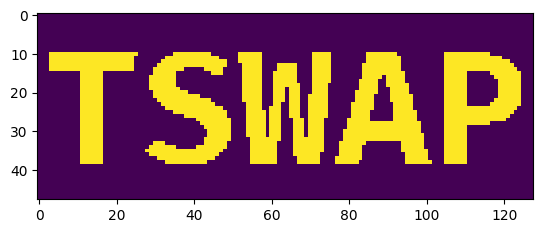

num_agents=1711, graph_size=(48, 128)


In [5]:
# Step 4. Visualise the results

Y = np.zeros_like(img)
for pos in target_positions:
    Y[pos[0], pos[1]] = 1
plt.imshow(Y)
plt.show()
print(f"num_agents={np.sum(Y)}, graph_size={Y.shape}")

In [6]:
# Step 5. Save map
map_file = Path(f"../assets/empty_{'_'.join(map(str, Y.shape))}.map")

with open(map_file, "w") as f:
    f.write(f"type octile\nheight {Y.shape[0]}\nwidth {Y.shape[1]}\nmap\n")
    for _ in range(Y.shape[0]):
        f.write("." * Y.shape[1] + "\n")

In [7]:
# Step 6. Generate starts
seed = 0
rng = np.random.default_rng(seed)
locs = list(product(range(Y.shape[1]), range(Y.shape[0])))
starts = rng.choice(locs, num_agents, replace=False)

In [8]:
scen_file = Path(f"../assets/empty_{'_'.join(map(str, Y.shape))}.scen")

with open(scen_file, "w") as f:
    f.write("version 1\n")
    for (s_x, s_y), (g_y, g_x) in zip(starts, target_positions):
        d = np.sqrt((s_x - g_x) ** 2 + (s_y - g_y) ** 2)
        f.write(
            f"1\t{scen_file.stem}.map\t{Y.shape[1]}\t{Y.shape[0]}\t{s_x}\t{s_y}\t{g_x}\t{g_y}\t{d}\n"
        )